In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy import sparse
from scipy import linalg
from scipy import special, pi
from scipy import integrate
from scipy.fft import fft, fftshift, fftfreq, ifft, ifft2, fft2, ifftshift
from scipy import signal
import os

In [2]:
au2cm = 219474.6305
auScale= 0.0000046
au2fs = 0.02418884254
scaling = 1.0

t_short = 10000 #(1.0e3 / au2fs) / scaling
t_learn = (1.0e3 / au2fs) / scaling
t_min = (1.0e-3 / au2fs) / scaling

n_pts = 5000
n_ltc = 10

log_domain = np.logspace(np.log2(t_min), np.log2(t_learn), num=int(n_pts), base=2)
#test_domain = np.logspace(np.log2(t_min), np.log2(t_test), num=n_pts, base=2)
learn_domain = np.linspace(0, t_learn*1.5, num=int(n_pts))
print(t_learn)

41341.37457575099


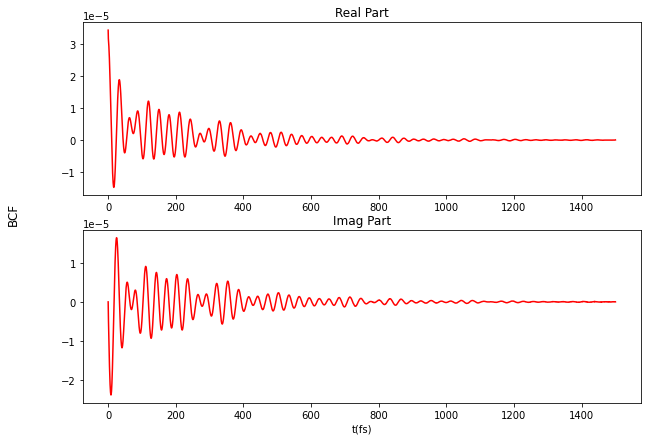

In [35]:
#file_learn = open('learn_db_10_short.csv', 'r')#for lin space x distribution
#file_learn = open('learn_db_10_lin_2000.csv', 'r')

#learn_s, test_s,learn_a, test_a = np.loadtxt(file_learn ,delimiter = ",")

#file_learn = open('BCF_SPD_TMD_1.csv', 'r')
file_learn = open('bcf_4_8.csv', 'r')
learn_s,learn_a = np.loadtxt(file_learn ,delimiter = ",")

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
peak_s, a = signal.find_peaks(learn_s)
peak_a, a = signal.find_peaks(abs(learn_a))
fig = plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax1.plot(learn_domain* au2fs, learn_s,'r-')
ax1.set_title('Real Part')
#plt.plot(learn_domain[peak_s]* au2fs, learn_s[peak_s], "x")
#plt.xscale('log')
ax2 = plt.subplot(212)
ax2.set_title('Imag Part')
ax2.set_xlabel('t(fs)')
ax2.plot(learn_domain* au2fs, learn_a,'r-')
#plt.plot(learn_domain[peak_a]* au2fs, learn_a[peak_a], "x")
#plt.xscale('log')
fig.supylabel('BCF')
plt.show()

<Figure size 1440x1440 with 0 Axes>

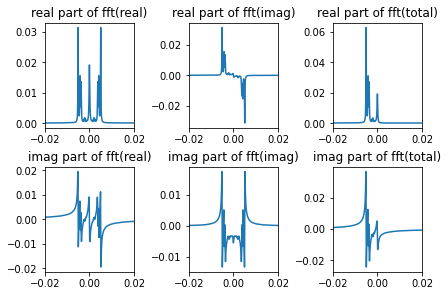

In [4]:
learn_r = torch.Tensor(learn_s)
learn_i = torch.Tensor(learn_a)

learn_r = torch.complex(learn_r, torch.zeros((n_pts,))).detach().numpy()
learn_i = torch.complex(torch.zeros((n_pts,)), learn_i).detach().numpy()

ft_shift_r = 2*np.pi*fftshift(fft(learn_r))
ft_shift_i = 2*np.pi*fftshift(fft(learn_i))
#annot_max(freq_r, ft_r)
n = np.arange(-n_pts/2, n_pts/2)
freq = 2*np.pi*(n/(n_pts*(learn_domain[1]-learn_domain[0])))
ft_shift_total = ft_shift_r + ft_shift_i

plt.figure(figsize = (20, 20))
fig, ax = plt.subplots(2, 3, layout="constrained")

ax[0, 0].plot(freq, ft_shift_r.real)
ax[0, 0].set_title('real part of fft(real)')
ax[0, 1].plot(freq, ft_shift_i.real)
ax[0, 1].set_title('real part of fft(imag)')
ax[0, 2].plot(freq, ft_shift_total.real)
ax[0, 2].set_title('real part of fft(total)')
ax[1, 0].plot(freq, ft_shift_r.imag)
ax[1, 0].set_title('imag part of fft(real)')
ax[1, 1].plot(freq, ft_shift_i.imag)
ax[1, 1].set_title('imag part of fft(imag)')
ax[1, 2].plot(freq, ft_shift_total.imag)
ax[1, 2].set_title('imag part of fft(total)')
ax[0, 0].set_xlim(-0.02, 0.02)
ax[0, 1].set_xlim(-0.02, 0.02)
ax[0, 2].set_xlim(-0.02, 0.02)
ax[1, 0].set_xlim(-0.02, 0.02)
ax[1, 1].set_xlim(-0.02, 0.02)
ax[1, 2].set_xlim(-0.02, 0.02)
plt.show()

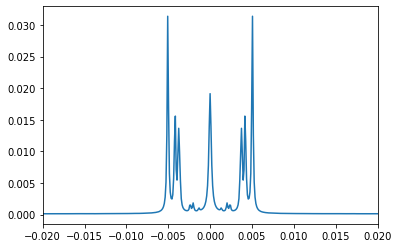

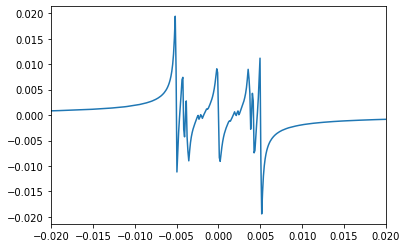

In [5]:
def Gaussian(x, x0, sigma):
    return np.exp(-(x - x0)**2/(2*sigma**2))/(2 * np.pi*sigma**2)
"""wide_ft_shift_r = np.convolve(ft_shift_r, Gaussian(freq, 0, 0.00027),'same')
wide_ft_shift_i = np.convolve(ft_shift_i, Gaussian(freq, 0, 0.00027),'same')
scale_r = max(wide_ft_shift_r)/max(ft_shift_r)
scale_i = max(wide_ft_shift_i)/max(ft_shift_i)
print(scale_r, scale_i)
wide_ft_shift_r /= scale_r
wide_ft_shift_i /= scale_i"""
#plt.plot(freq, wide_ft_shift_r.real)
plt.plot(freq, ft_shift_r.real)
plt.xlim(-0.02, 0.02)
plt.show()
#plt.plot(freq, wide_ft_shift_r.imag)
plt.plot(freq, ft_shift_r.imag)
plt.xlim(-0.02, 0.02)
plt.show()

In [6]:
learn_r = torch.Tensor(learn_s)
learn_i = torch.Tensor(learn_a)
learn = torch.complex(learn_r, learn_i)
init = learn[0]
learn = learn.detach().numpy()
print(init)

tensor(3.4331e-05-0.j)


In [7]:
ft = fft(learn)
ft_shift = 2*np.pi*fftshift(ft)
ft_norm = (ft_shift*(ft_shift.conjugate()))/(integrate.simps(ft_shift*(ft_shift.conjugate()), dx = 5e-2))
n = np.arange(-n_pts/2, n_pts/2)
freq = 2*np.pi*(n/(n_pts*(learn_domain[1]-learn_domain[0])))

In [8]:
#find local maximum and local minimum
peak_ft_r, _ = signal.find_peaks(ft_shift.real, prominence = (0.01* max(ft_shift.real),))
peak_matching_real, _ = signal.find_peaks(ft_shift.real) # include more small peak that for the matching
#freq[peak_matching_real]
peak_ft_i, _ = signal.find_peaks(abs(ft_shift.imag), prominence = (0.01* max(abs(ft_shift.imag)),))

# initialize a

In [9]:
#make them as functions that can find value given k
ft_shift_i_k = scipy.interpolate.interp1d(freq, ft_shift.imag, bounds_error=False, fill_value=(0,0))
ft_shift_r_k = scipy.interpolate.interp1d(freq, ft_shift.real, bounds_error=False, fill_value=(0,0))
ft_shift_rr_k = scipy.interpolate.interp1d(freq, ft_shift_r.real, bounds_error=False, fill_value=(0,0))
ft_shift_ir_k = scipy.interpolate.interp1d(freq, ft_shift_i.real, bounds_error=False, fill_value=(0,0))
ft_shift_ii_k = scipy.interpolate.interp1d(freq, ft_shift_i.imag, bounds_error=False, fill_value=(0,0))
ft_shift_ri_k = scipy.interpolate.interp1d(freq, ft_shift_r.imag, bounds_error=False, fill_value=(0,0))

In [10]:
dim = 3
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return idx, arr[idx]
# to find symm real peak positions # which indicate a value
posi_real_peak = np.where(freq[peak_ft_r] >0)
nega_real_peak = np.where(freq[peak_ft_r] <0)

if len(posi_real_peak[0]) > len(nega_real_peak[0]):
    #target_peak_posi = freq[peak_ft_r][nega_real_peak] # shorter one so no worries about the index
    target_peak_posi = freq[peak_ft_r][posi_real_peak] # no worries with above, now prefer matching with more pro
    target_peak_value = ft_shift[peak_ft_r][posi_real_peak].real
    match_peak_posi  = - freq[peak_matching_real]#freq[peak_ft_r][posi_real_peak]  # longer and complete one prominence peak
else:
    target_peak_posi = freq[peak_ft_r][nega_real_peak]
    target_peak_value = ft_shift[peak_ft_r][nega_real_peak].real
    match_peak_posi  = - freq[peak_matching_real] #freq[peak_ft_r][nega_real_peak]
    
a_array = np.zeros((len(target_peak_posi), ))
a_pair = np.zeros((len(target_peak_posi), 3)) # a, a reflection, peak value
for i in range(len(target_peak_posi)):
    idx, matched_peak_posi = find_closest(match_peak_posi, target_peak_posi[i])
    a_value = np.average([matched_peak_posi, target_peak_posi[i]])
    a_array[i] = target_peak_posi[i]#a_value
    a_pair[i,0] = target_peak_posi[i]
    a_pair[i,1] = - target_peak_posi[i]
    a_pair[i,2] = target_peak_value[i]
#a_pair = a_pair.reshape(len(target_peak_posi), 2)
a_pair_sorted = a_pair[a_pair[:, 2].argsort()[::-1]] #from highest peak to lowest peak
#
a_actual = np.zeros((len(target_peak_posi), 2))
a = np.zeros((dim,))
if 0 in freq[peak_ft_r]:# means real FT peaked at 0
    dim += 1
    #a[1:dim] = a_array[:dim -1]
    save_a_actual = a_pair_sorted[:dim-1,:2]
    print(a_pair_sorted[:dim])
    a_actual[0] = np.array([0,0])
    a_actual[1:dim] = save_a_actual
    a = a_actual[0:dim, 1]
    #a[:-1] = a_actual[0:dim-1, 1]
    #a[1] = a_actual[2, 1]
else:
    #print("a = ", a_array[:dim])
    #print(a_pair_sorted)
    a_actual = a_pair_sorted[:dim,:2]
    a = a_actual[:,1]
    #a_actual[:] 
    #a[:-1] = -a_actual[:dim-1,0]
    #a[-1] = -a_array[dim]
    
#print(a_actual[:dim])
#print(-a_array[0])
print(a)

[[-0.00506509  0.00506509  0.06263977]
 [-0.00415337  0.00415337  0.03101091]
 [-0.00374816  0.00374816  0.02713112]
 [-0.00202603  0.00202603  0.00344804]]
[0.         0.00506509 0.00415337 0.00374816]


In [11]:
0 in a

True

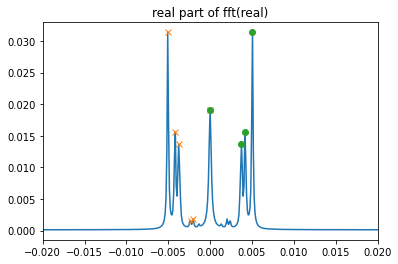

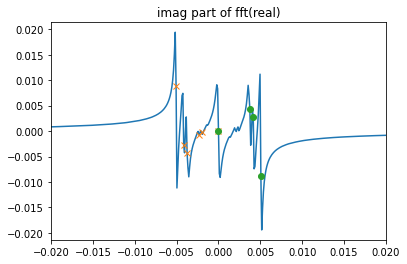

In [12]:
plt.plot(freq, ft_shift_r.real)
plt.plot(freq[peak_ft_r], ft_shift_r[peak_ft_r].real, "x")
plt.plot(a[:dim], ft_shift_rr_k(a[:dim]), 'o')
plt.xlim(-0.02,0.02)
plt.title('real part of fft(real)')
plt.show()


plt.plot(freq, ft_shift_r.imag)
plt.plot(freq[peak_ft_r], ft_shift_r[peak_ft_r].imag, "x")
plt.plot(a[:dim], ft_shift_ri_k(a[:dim]), 'o')
plt.title('imag part of fft(real)')
plt.xlim(-0.02,0.02)
plt.show()

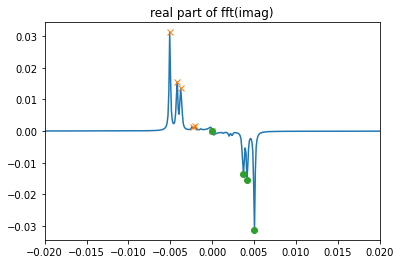

In [13]:
plt.plot(freq, ft_shift_i.real)
plt.plot(freq[peak_ft_r], ft_shift_i[peak_ft_r].real, "x")
plt.plot(a[:dim], ft_shift_ir_k(a[:dim]), 'o')
plt.title('real part of fft(imag)')
plt.xlim(-0.02,0.02)
plt.show()

# initialize s

Try a easier way to find s:
1. pair the upper and lower peaks up, we get some pair ranges
2. if our a value falls into one range, get the corresponding s
3. since a is in pairs, find the average value of s in one a
4. if there is cc = -c, means the imag part will be symmetry, we have to cut it half and fill the rest

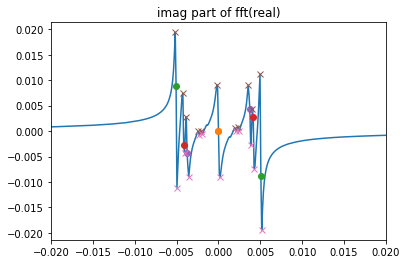

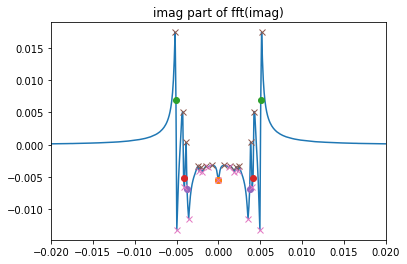

In [14]:
# up_xxx down_xxx indicate the peak is up or down
up_r_ft_i_peak, _ = signal.find_peaks(ft_shift_r.imag, prominence = (0.01* max(ft_shift_r.imag),))
down_r_ft_i_peak, _ = signal.find_peaks(-ft_shift_r.imag, prominence = (0.01* max(-ft_shift_r.imag),))
up_i_ft_i_peak, _ = signal.find_peaks(ft_shift_i.imag, prominence = (0.01* max(ft_shift_i.imag),))
down_i_ft_i_peak, _ = signal.find_peaks(-ft_shift_i.imag, prominence = (0.01* max(-ft_shift_i.imag),))

use_function = ft_shift_r.imag # we select since its peak is more easy to realize
a_double = np.zeros((dim, 2))
a_double[:,1] = a
a_double[:,0] = -a
plt.plot(freq, ft_shift_r.imag)
for i in range(dim):
    plt.plot(a_double[i], ft_shift_ri_k(a_double[i]),"o")

plt.plot(freq[up_r_ft_i_peak], ft_shift_r[up_r_ft_i_peak].imag,"x")
plt.plot(freq[down_r_ft_i_peak], ft_shift_r[down_r_ft_i_peak].imag,"x")
plt.xlim(-0.02,0.02)
plt.title('imag part of fft(real)')
plt.show()

plt.plot(freq, ft_shift_i.imag)
for i in range(dim):
    plt.plot(a_double[i], ft_shift_ii_k(a_double[i]),"o")
plt.plot(freq[up_i_ft_i_peak], ft_shift_i[up_i_ft_i_peak].imag,"x")
plt.plot(freq[down_i_ft_i_peak], ft_shift_i[down_i_ft_i_peak].imag,"x")
plt.xlim(-0.02,0.02)
plt.title('imag part of fft(imag)')
plt.show()

 from the diagram above we can find that there will be a positive peak and its coupled negative peak
 so use the positive one to match the negative one.
 the matched peak pairs should satidfied:
1. have same distance(s value) to the a_value 
2. since a_value appears to be into the positive and negative pair so the 4 s_value should be the same
3. if there will be more than one choice, choose the smaller one, due to the function properties(smaller s more wave peak after ifft)

Firstly, use this graph "ft_shift_r.imag" since its peak is more easy to realize\
Then, do some matching and make sure to capture the peak on "ft_shift_i.real"

In [15]:
use_function = ft_shift_r.imag # we select since its peak is more easy to realize
def find_s_information(use_function):
    up_r_ft_i_peak, _ = signal.find_peaks(use_function, prominence = (0.01* max(use_function),))
    down_r_ft_i_peak, _ = signal.find_peaks(-use_function, prominence = (0.01* max(-use_function),))

    if (np.round(freq[up_r_ft_i_peak[0]], decimals = 5) < np.round(freq[down_r_ft_i_peak[0]], decimals = 5) 
        and np.round(freq[up_r_ft_i_peak[-1]], decimals = 5) < np.round(freq[down_r_ft_i_peak[-1]], decimals = 5)): # c and cc posi
        # the left one is positive and the right one is negative
        find_s_array = np.zeros((len(up_r_ft_i_peak), 3)) #left bound,right bound, indicated s
        for i, value in enumerate(freq[up_r_ft_i_peak]):
            try:
                find_s_array[i][0] = value
                find_s_array[i][1] = freq[down_r_ft_i_peak][i]
                find_s_array[i][2] = (freq[down_r_ft_i_peak][i] - value)/2 # the s value we want
            except IndexError:
                break


    elif (np.round(freq[up_r_ft_i_peak[0]], decimals = 5) > np.round(freq[down_r_ft_i_peak[0]], decimals = 5) 
          and np.round(freq[up_r_ft_i_peak[-1]], decimals = 5) > np.round(freq[down_r_ft_i_peak[-1]], decimals = 5)):# c and cc nega
        find_s_array = np.zeros((len(down_r_ft_i_peak), 3)) 
        for i, value in enumerate(freq[down_r_ft_i_peak]):
            try:
                find_s_array[i][0] = value
                find_s_array[i][1] = freq[up_r_ft_i_peak][i]
                find_s_array[i][2] = (freq[up_r_ft_i_peak][i] - value)/2
            except IndexError:
                break

    else: # they are symmetrical, the left most and right most peak is both posi or nega
        # if upper peak number is greater, then it means the two outer peak is up
        # no matter which one is longer (up or down) the even one will indicate the number of peaks
        # and there will only be one even list
        if len(up_r_ft_i_peak)%2 == 0: # up_r_ft_i_peak is even
            find_s_array = np.zeros((len(up_r_ft_i_peak), 3))
            for i, value in enumerate(freq[up_r_ft_i_peak][:int(len(up_r_ft_i_peak)/2)]):
                find_s_array[i][0] = value
                find_s_array[i][1] = freq[down_r_ft_i_peak][i]
                find_s_array[i][2] = (freq[down_r_ft_i_peak][i] - value)/2 # the s value we want
            find_s_array[int(len(up_r_ft_i_peak)/2): ][:2] = - find_s_array[:int(len(up_r_ft_i_peak)/2)][:2]
            find_s_array[int(len(up_r_ft_i_peak)/2): ][2] = find_s_array[:int(len(up_r_ft_i_peak)/2)][2]        
        else: # down_r_ft_i_peak is even
            find_s_array = np.zeros((len(down_r_ft_i_peak), 3))
            for i, value in enumerate(freq[down_r_ft_i_peak][:int(len(down_r_ft_i_peak)/2)]):
                find_s_array[i][0] = freq[up_r_ft_i_peak][i]
                find_s_array[i][1] = value
                find_s_array[i][2] = (value - freq[up_r_ft_i_peak][i])/2 # the s value we want
        # we need to fill the rest half 
        # first do mirror relfection
        #print(find_s_array)
        find_s_array[int(len(find_s_array)/2):] = find_s_array[:int(len(find_s_array)/2)][::-1]
        
        #third column stays the same
        #second and first column be inverse sign and exchange position
        be_1 = np.copy(find_s_array[int(len(find_s_array)/2):,0])*-1
        be_0 = np.copy(find_s_array[int(len(find_s_array)/2):,1])*-1
        
        find_s_array[int(len(find_s_array)/2):,0] = be_0
        find_s_array[int(len(find_s_array)/2):,1] = be_1
    #print(find_s_array)
    s = np.zeros((dim,2))#2 comes from: one is for a one is for s
    s_bound = np.zeros((dim,2))
    for i, value_i in enumerate(a):
        for j, value_j in enumerate(find_s_array):
            if value_i >= value_j[0] and value_i <= value_j[1]:
                s[i][0] = value_i
                s[i][1] = value_j[2]
                s_bound[i] = value_j[:2]
    return s, s_bound
s, s_bound = find_s_information(use_function)

print(s)
print(s_bound)

[[0.         0.0002026 ]
 [0.00506509 0.0001013 ]
 [0.00415337 0.0001013 ]
 [0.00374816 0.00015195]]
[[-0.0002026   0.0002026 ]
 [ 0.00496378  0.00516639]
 [ 0.00405207  0.00425467]
 [ 0.00354556  0.00384947]]


In [16]:
s_ii, s_bound_ii = find_s_information(ft_shift_i.imag)
print(s_ii)
print(s_bound_ii)

[[0.         0.00035456]
 [0.00506509 0.0001013 ]
 [0.00415337 0.0001013 ]
 [0.00374816 0.00015195]]
[[-0.          0.00070911]
 [ 0.00496378  0.00516639]
 [ 0.00405207  0.00425467]
 [ 0.00354556  0.00384947]]


a_value determines the frequency of oscillation: larger a higher frequency

s_value determines the duration of the oscillaton: larger s shorter duration

frequency must be different, duration can be the same

# initialize Cr Ci CCr CCi

This part still has some problem (The initial value still looks wrong)

From the characteristic of the real and imag part of the transfored function, we can see that the coeffs can be extracted from the function:

Noticed that, the real part can be decomposed into two part:
1. contributed by c_r
2. contributed by c_i

the real part coeffs c_r and cc_r can be find from idea that\
in ft_shift_r.real $peak = \frac{\frac{c_r + cc_r}{2}}{s}= \frac{c_r + cc_r}{2s}$

in ft_shift_i.imag $peak = i\times i\frac{\frac{c_r - cc_r}{2}}{s} = \frac{cc_r - c_r}{2s}$

the imag part coeffs c_i and cc_i can be find from idea that\
in ft_shift_i.real $peak = i\times i\frac{\frac{c_i + cc_i}{2}}{2s} = -\frac{c_i + cc_i}{4s}$

in ft_shift_r.imag $peak =  i\frac{\frac{cc_i - c_i}{2}}{2s} = - \frac{c_i - cc_i}{4s}$

In [17]:
a_s_ri = np.zeros((dim, 4)) # there will be 4 value prerow
a_s_ii = np.zeros((dim, 4))
for i in range(dim):
    a_s_ri[i][:2] = -s_bound[i]
    a_s_ri[i][2:] = s_bound[i]
    a_s_ii[i][:2] = -s_bound_ii[i]
    a_s_ii[i][2:] = s_bound_ii[i]
    
c_r = np.zeros((dim,))
cc_r = np.zeros((dim,))
c_i = np.zeros((dim,))
cc_i = np.zeros((dim,))
c_rpcc_r = np.zeros((dim,))
cc_rmc_r = np.zeros((dim,))# since a_s is dim x 4 shape
c_ipcc_i = np.zeros((dim,)) 
cc_imc_i = np.zeros((dim,))

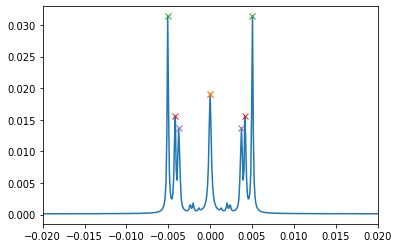

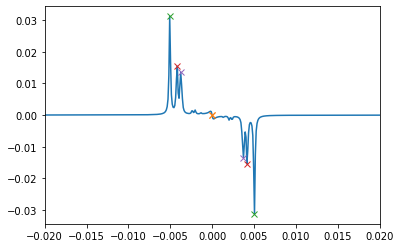

In [18]:
plt.plot(freq, ft_shift_r.real)
for i in range(dim):
    plt.plot(a_double[i], ft_shift_rr_k(a_double[i]), 'x')
    c_rpcc_r[i] = np.average(ft_shift_rr_k(a_double[i]) * 2 * s[i,1])
    cc_rmc_r[i] = ft_shift_rr_k(a[i]) * 2 * s_ii[i,1]
plt.xlim(-0.02, 0.02)
plt.show()

plt.plot(freq, ft_shift_i.real)
for i in range(dim):
    plt.plot(a_double[i], ft_shift_ir_k(a_double[i]), 'x')
plt.xlim(-0.02, 0.02)
plt.show()

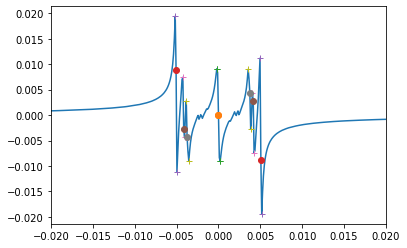

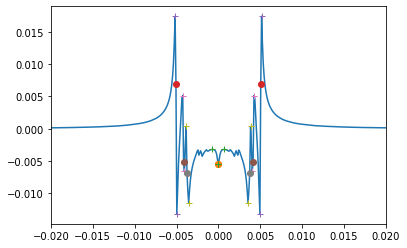

In [19]:
plt.plot(freq, ft_shift_r.imag)
for i in range(dim):
    plt.plot(a_double[i], ft_shift_ri_k(a_double[i]),"o")
    #plt.plot(a_s_ri[i], ft_shift_ii_k(a_s_ri[i]),"x")
    plt.plot(a_s_ri[i], ft_shift_ri_k(a_s_ri[i]),"+")
plt.xlim(-0.02, 0.02)
plt.show()

plt.plot(freq, ft_shift_i.imag)
for i in range(dim):
    plt.plot(a_double[i], ft_shift_ii_k(a_double[i]),"o")
    #plt.plot(a_s_ri[i], ft_shift_ii_k(a_s_ri[i]),"x")
    plt.plot(a_s_ii[i], ft_shift_ii_k(a_s_ii[i]),"+")
plt.xlim(-0.02, 0.02)
plt.show()



In [20]:
for i in range(dim):
    peak_height_ii = np.abs(ft_shift_ii_k(s_bound_ii[i,0]) - ft_shift_ii_k(s_bound_ii[i,1]))/2
    peak_height_ri = np.abs(ft_shift_ri_k(s_bound[i,0]) - ft_shift_ri_k(s_bound[i,1]))/2
    ft_shift_ir_k(a_s_ri[i][0]) 
    c_ipcc_i[i] = peak_height_ii * 4 * s[i,1]
    cc_imc_i[i] = peak_height_ri * 4 * s_ii[i,1] - c_rpcc_r[i]

print(c_rpcc_r)
print(cc_rmc_r)
print(c_ipcc_i)
print(cc_imc_i)
c_r = (c_rpcc_r - cc_rmc_r)/2
c_i = (c_ipcc_i - cc_imc_i)/2
cc_r = (c_rpcc_r + cc_rmc_r)/2
cc_i = (c_ipcc_i + cc_imc_i)/2
# some c_imcc_i  and c_rmcc_r are not same
# so we need to further process them
# due to c_imcc_i comes from a_s_ri which it will envolves two pairs
# each pair has a upper value and a lower value
# for example ft_shift_ri_k,
# left peak indicate (1/4s)(c_rpcc_r + c_imcc_i) right peak indicate (1/4s)(c_rpcc_r - c_imcc_i)

r_sum = np.sum(c_r) + np.sum(cc_r)

c_r = c_r/r_sum * init.real.detach().numpy()
cc_r = cc_r/r_sum * init.real.detach().numpy()
print('-------------------')
print(c_r)
print(cc_r)
print(c_i)
print(cc_i)

[7.75431092e-06 6.35877607e-06 3.15770722e-06 4.14992026e-06]
[1.35700441e-05 6.35877569e-06 3.15770737e-06 4.14992026e-06]
[9.05346070e-07 6.20171885e-06 2.37450432e-06 3.58994749e-06]
[ 5.13311741e-06 -1.64654880e-07 -7.91473983e-07 -5.77050185e-07]
-------------------
[-4.66041375e-06  3.02410560e-13 -1.13403960e-13  0.00000000e+00]
[1.70881838e-05 1.01911575e-05 5.06083138e-06 6.65104290e-06]
[-2.11388567e-06  3.18318686e-06  1.58298915e-06  2.08349884e-06]
[3.01923174e-06 3.01853198e-06 7.91515167e-07 1.50644865e-06]


# star NN

In [21]:
a_torch = torch.tensor(a)#, requires_grad=True)
s_torch = torch.tensor(s[:,1])#, requires_grad=True)
c_r_np = np.zeros((dim*2,))
c_r_np[:dim] = c_r
c_r_np[dim:] = cc_r
c_r_torch = torch.tensor(c_r_np)#, requires_grad=True)
c_i_np = np.zeros((dim*2,))
c_i_np[:dim] = c_i
c_i_np[dim:] = cc_i
c_i_torch = torch.tensor(c_i_np)#, requires_grad=True)

In [22]:
class Odd_terms(nn.Module):
    def __init__(self, dim, init, c_r, c_i, eta_r, eta_i):
        super().__init__()
        self.init_r = init.real
        self.init_i = init.imag
        self.eta_r = nn.Parameter(eta_r.clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim, requires_grad=True)*scale)
        self.dim = dim - 1
        self.c0_i = nn.Parameter(c_i[0].detach().requires_grad_(True))
        self.c0_r = c_r[0]
        _c_i = torch.zeros((self.dim*2))
        _c_r = torch.zeros((self.dim*2))
        _c_r[:self.dim] = c_r[1:dim]
        _c_i[:self.dim] = c_i[1:dim]
        _c_r[self.dim:] = c_r[dim+1:2*dim]
        _c_i[self.dim:] = c_i[dim+1:2*dim]
        self.c_r = nn.Parameter(_c_r[:self.dim*2-1].clone().detach().requires_grad_(True))
        self.c_i = nn.Parameter(_c_i[:self.dim*2-1].clone().detach().requires_grad_(True))
        self.eta_i = nn.Parameter(eta_i[1:].clone().detach().requires_grad_(True))
        return

    def forward(self, t):
        t0 = torch.unsqueeze(t, -1)
        t = torch.unsqueeze(t, -1).expand(-1, self.dim)
        self.c0 = torch.complex(self.c0_r, self.c0_i)
        c_r_correction = self.init_r - torch.sum(self.c_r) - self.c0.real
        c_i_correction = self.init_i - torch.sum(self.c_i) - self.c0.imag
        c = torch.zeros((self.dim * 2 + 1,), dtype = torch.complex128)
        c[-1] = torch.complex(c_r_correction, c_i_correction)
        c[0] = self.c0
        c[1:-1] = torch.complex(self.c_r, self.c_i)
        eta_0 =  torch.complex(self.eta_r[0], torch.zeros(1,dtype=torch.float64))
        eta =  torch.complex(self.eta_r[1:], self.eta_i)
        eta_total = torch.zeros((self.dim+1,), dtype = torch.complex128)
        eta_total[0] = eta_0
        eta_total[1:] = eta
        self.eta = eta_total
        self.c = c
        c_t = c[1:self.dim+1]* torch.exp(eta * t) + c[self.dim+1:]* torch.exp(torch.conj(eta) * t)
        _sum = torch.sum(self.c0* torch.exp(eta_0 * t0), dim = -1) + torch.sum(c_t, dim = -1)
        return _sum#.real, _sum.imag

In [23]:
class Even_terms(nn.Module):
    def __init__(self, dim, init, c_r, c_i, eta_r, eta_i):
        super().__init__()
        self.dim = dim
        scale  = 1e-6
        self.init_r = init.real
        self.init_i = init.imag
        self.c_i = nn.Parameter(c_r[:dim*2-1].clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim * 2 - 1, requires_grad=True)*scale)
        self.c_r = nn.Parameter(c_i[:dim*2-1].clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim * 2 - 1, requires_grad=True)*scale)
        self.eta_i = nn.Parameter(eta_i.clone().detach().requires_grad_(True))
        self.eta_r = nn.Parameter(eta_r.clone().detach().requires_grad_(True))#nn.Parameter(torch.rand(self.dim, requires_grad=True)*scale)
        #self.eta_r = eta_r
        #self.eta_i = eta_i
        return

    def forward(self, t):
        t0 = torch.unsqueeze(t, -1)
        t = torch.unsqueeze(t, -1).expand(-1, self.dim)
        #print(torch.sum(self.c_r))
        c_r_correction = self.init_r - torch.sum(self.c_r) # to let real and imag part have the correct inital value
        c_i_correction = self.init_i - torch.sum(self.c_i)
        #c = torch.complex(self.c_r, self.c_i)
        c = torch.zeros((self.dim * 2,), dtype = torch.complex128)
        c[-1:] = torch.complex(c_r_correction, c_i_correction)
        c[:-1] = torch.complex(self.c_r, self.c_i)
        eta = torch.complex(self.eta_r, self.eta_i)
        self.eta = eta
        self.c = c
        i = torch.complex(torch.zeros((1)),torch.ones((1)))
        c_t = c[:self.dim]* torch.exp(eta * t) + c[self.dim:]* torch.exp(torch.conj(eta) * t)
        
        
        return torch.sum(c_t, dim = -1)

In [24]:
class LagM_Even(nn.Module):
    def __init__(self, dim, init, c_r, c_i, eta_r, eta_i):
        super().__init__()
        self.dim = dim
        scale  = 1e-6
        self.init_r = init.real
        self.init_i = init.imag
        self.c_i = nn.Parameter(c_r[:dim*2-1].clone().detach().requires_grad_(True))        
        self.c_r = nn.Parameter(c_i[:dim*2-1].clone().detach().requires_grad_(True))
        self.eta_i = nn.Parameter(eta_i.clone().detach().requires_grad_(True))
        #self.eta_r = nn.Parameter(eta_r.clone().detach().requires_grad_(True))
        self.eta_r = eta_r
        #self.L_lambda = nn.Parameter(torch.rand(self.dim, requires_grad=True))
        
        #self.a0 = nn.Parameter(torch.rand(1, requires_grad=True)* scale)
        self.b0 = nn.Parameter(torch.rand(1, requires_grad=True)* scale)
        self.c0 = nn.Parameter(torch.rand(1, requires_grad=True)* scale)
        self.b1 = nn.Parameter(torch.rand(1, requires_grad=True)* scale)
        self.c1 = nn.Parameter(torch.rand(1, requires_grad=True)* scale)
        
        #Not Now !!! #f = exp(log1 * t) + b * (log2 * t)
        #Now : C(t) = sum_k(c_k f_k); f_k = sum_n(d_kn exp(eta_kn t))

        self.gamma = nn.Parameter(torch.rand(3, requires_grad=True)*scale)
        self.gammaoffdiag = nn.Parameter(torch.rand(2, requires_grad=True))
        self.gammaoffdiag_2 = nn.Parameter(torch.rand(1, requires_grad=True))
        #self.gammamatrix = torch.diag(self.gamma) + torch.diag(self.gammaoffdiag, 1)# have the matrix with diagnal gamma and off-diag 1 
        
        return

    def forward(self, t):
        t_pts = len(t)
        t = torch.unsqueeze(t, -1).expand(-1, self.dim*2)#* (1000 / au2cm)
        c_r_correction = self.init_r - torch.sum(self.c_r) # to let real and imag part have the correct inital value
        c_i_correction = self.init_i - torch.sum(self.c_i)
        #c = torch.complex(self.c_r, self.c_i)
        c = torch.zeros((self.dim * 2,), dtype = torch.complex128)
        c[-1:] = torch.complex(c_r_correction, c_i_correction)
        c[:-1] = torch.complex(self.c_r, self.c_i)
        eta = torch.zeros((self.dim * 2,), dtype = torch.complex128)
        eta[:dim] = torch.complex(self.eta_r, self.eta_i)
        eta[dim:] = torch.conj(eta[:dim])
        self.eta = eta
        self.c = c
        # old f = d exp(eta t)
        # new f1 = d0 exp(eta t)
            # f2 = (d0 + d1 t)exp(eta t)
            # f3 = (d0 + d1 t + d2 t^2)exp(eta t)
        # new f1' = d0 eta exp(eta t) = eta f1
            # f2' = eta (d0 + d1 t) exp(eta t) + (d1/d0) d0 exp(eta t) = eta f2 + (d1/d0) f1
            # f3' = eta (d0 + d1 t + d2 t^2)exp(eta t) + (d1 + 2 * d2 t)exp(eta t) 
                # = eta f3 + (2 * d2/d1)(d0 + d1 t)exp(eta t) + (d1 - (2 * d2/d1)*d0)exp(eta t)
                # = eta f3 + (2 * d2/d1) f2 + (d1/d0 - (2 * d2/d1))d0 exp(eta t)
        #f3 = d[4:6] * torch.exp(eta[4:6] * t)
        #f2 = d[2:4] * torch.exp(eta[2:4] * t)
        #f1 = c[0:2] * torch.exp(eta[0:2] * t)
        #exp_sum = torch.sum(torch.exp(eta * t), dim = -1)
        f3 = torch.exp(eta * t) * c
        f2 = f3 * (self.b0 + self.b1 * t)
        f1 = f2 * (self.c0 + self.c1 * t)
        # 6 of each eta :3 pairs, d1 d2 d3... is number 
        df_dt_3 = eta * f3
        df_dt_2 = eta * f2 + self.b1 * f3
        df_dt_1 = eta * f1 + self.c1 * eta * f2 + self.c1 * self.b1 * f3
        
        L_lambda = 0.01 # here set a uniform value 0.01
        gammaoffdiag = torch.sigmoid((self.gammaoffdiag - 0.5)*50)
        gammaoffdiag_2 = torch.sigmoid((self.gammaoffdiag_2 - 0.5)*50)

        _sum =  torch.sum(f1 + f2 + f3, dim = -1) # for G_0  #
        #print(_sum.shape, f1.shape)
        G1 = df_dt_1 - (self.gamma[0] * f1 + torch.round(gammaoffdiag[0]) * f2 + torch.round(gammaoffdiag_2[0]) * f3)# matrix multiplication, Now G.shape = (K, t_pts) 
        G2 = df_dt_2 - (self.gamma[1] * f2 + torch.round(gammaoffdiag[1]) * f3)
        G3 = df_dt_3 - (self.gamma[2] * f3 )
        
        Lag_loss = torch.sum(L_lambda * G1 + L_lambda * G2 + L_lambda * G3, dim = -1)
        
        self.f1_t0 = f1[0]
        self.f2_t0 = f2[0]
        self.f3_t0 = f3[0]
        self.gammamatrix = torch.diag(self.gamma) + torch.diag(self.gammaoffdiag, 1) + torch.diag(self.gammaoffdiag_2, 2)
        return _sum, Lag_loss

In [28]:
if 0 in a:
    network_t = Odd_terms(dim, init, c_r_torch, c_i_torch, -s_torch, -a_torch)
else:
    network_t = Even_terms(dim, init, c_r_torch, c_i_torch, -s_torch, -a_torch)
#network_t = LagM_Even(dim, init, c_r_torch, c_i_torch, -s_torch, -a_torch)

loss_list = []
log_domain = np.logspace(np.log2(t_min), np.log2(t_learn), num=5000, base=2)
optimizer_d_r_i = optim.Adam(network_t.parameters(), lr=5e-9)#1e-7 best for 5e-5
#learn_domain_tensor = torch.tensor(learn_domain_short).float()
#learn = torch.complex(torch.tensor(learn_s_short), torch.tensor(learn_a_short))
file_log = open('bcf_4_9.csv', 'r')
learn_s_log,learn_a_log = np.loadtxt(file_log ,delimiter = ",")
learn_domain_tensor = torch.tensor(learn_domain).float()
learn = torch.complex(torch.tensor(learn_s), torch.tensor(learn_a))

lossfunc = nn.L1Loss() #nn.MSELoss()
for n in range(150000):
    #_sum_r, _sum_i = network_t(learn_domain_tensor)
    #loss_r = lossfunc(_sum_r, 3* learn.real)
    #loss_i = lossfunc(_sum_i, learn.imag)
    #------ for Lagrange Multi
    #_sum, Lag_loss = network_t(learn_domain_tensor)
    #loss1 = lossfunc(_sum, learn) 
    #loss2 = lossfunc(Lag_loss,torch.zeros(n_pts))
    #loss = loss_r + loss_i
    _sum = network_t(learn_domain_tensor)
    loss = lossfunc(_sum, learn)
    #------
    if n == 0:
        #initial_value = _sum.detach().clone()
        print(network_t.eta)
        print(network_t.c)
    #loss_i = lossfunc(hat_d_i, learn_i)
    #loss = loss_r + loss_i
    
    loss_list.append(loss.item())
    
    optimizer_d_r_i.zero_grad()   
    loss.backward()
    optimizer_d_r_i.step()
    if (n)%5000 == 0:
        print(f"{n}: {loss.item()}")

tensor([-0.0002+0.0000j, -0.0001-0.0051j, -0.0001-0.0042j, -0.0002-0.0037j],
       dtype=torch.complex128, grad_fn=<CopySlices>)
tensor([-4.6604e-06-7.2068e-07j,  3.0241e-13+3.1832e-06j,
        -1.1340e-13+1.5830e-06j,  0.0000e+00+2.0835e-06j,
         1.0191e-05+3.0185e-06j,  5.0608e-06+7.9152e-07j,
         2.3739e-05-9.9390e-06j], dtype=torch.complex128, grad_fn=<CopySlices>)
0: 3.790849097823e-06
5000: 9.873966520265295e-07
10000: 9.459234896733917e-07
15000: 9.159196899507076e-07
20000: 8.929475792267541e-07
25000: 8.748922441009258e-07
30000: 8.603958267633531e-07
35000: 8.485465503878804e-07
40000: 8.387124052160199e-07
45000: 8.304431246340175e-07
50000: 8.234098031049492e-07
55000: 8.17367520874385e-07
60000: 8.121291847504472e-07
65000: 8.075514716279052e-07
70000: 8.03523060744035e-07
75000: 7.999552945046722e-07
80000: 7.967767820747752e-07
85000: 7.93928735522429e-07
90000: 7.913620906857047e-07
95000: 7.890389506857681e-07
100000: 7.869280435321249e-07
105000: 7.8500390

In [29]:
#Coefficient for Model Even_terms(nn.Module) and Odd_terms(nn.Module)
eta = network_t.eta
c = network_t.c
print(c)
torch.set_printoptions(precision=7)
print(eta)

tensor([-4.6604e-06+3.0503e-07j,  1.3167e-05-1.4090e-06j,
         9.3240e-06-2.9789e-06j,  1.1675e-05+5.5237e-06j,
         9.1919e-07+2.4933e-07j,  1.3906e-06+1.3542e-07j,
         2.5148e-06-1.8256e-06j], dtype=torch.complex128, grad_fn=<CopySlices>)
tensor([-1.6652545e-03+0.0000000j, -9.8284097e-05-0.0050464j,
        -1.2965498e-04-0.0041660j, -1.8431937e-04-0.0037959j],
       dtype=torch.complex128, grad_fn=<CopySlices>)


In [26]:
#Coefficient for Model LagM_Even(nn.Module)
eta = network_t.eta
c = network_t.c
Mat = network_t.gammamatrix
f1_t0 = network_t.f1_t0
f2_t0 = network_t.f2_t0
f3_t0 = network_t.f3_t0

#print(eta)
#print(c)
#print(Mat)
#print(f1_t0)
#print(f2_t0)
#print(f3_t0)

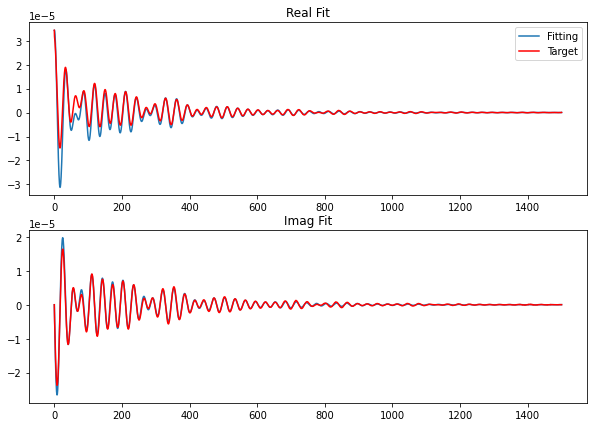

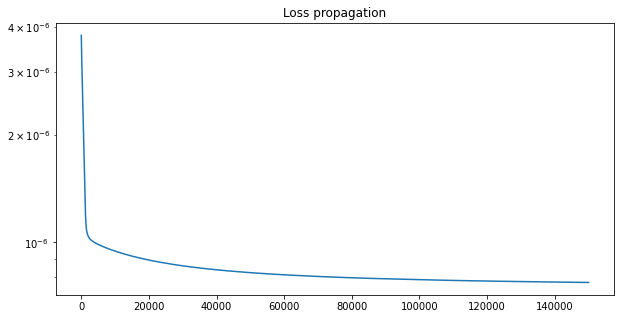

In [30]:
final_value = network_t(torch.tensor(learn_domain))#torch.tensor(test_domain))
#final_value,_ = network_t(learn_domain_tensor)
plot_r = final_value.real #initial_value.real
plot_i = final_value.imag#final_value
plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax1.set_title('Real Fit')
#ax1.set_xscale('log')
ax1.plot(learn_domain* au2fs, plot_r.detach().numpy().flatten(),label ='Fitting')
#ax1.plot(learn_domain* au2fs, initial_value.real.detach().numpy().flatten())
#ax1.plot(log_domain* au2fs, learn_s_log, 'r-',label ='Target')
ax1.plot(learn_domain* au2fs, learn_s, 'r-',label ='Target')
ax1.legend()

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_title('Imag Fit')
#ax2.set_xscale('log')
#x2.plot(log_domain* au2fs, plot_i.detach().numpy().flatten(),label ='Fitting')
ax2.plot(learn_domain* au2fs, plot_i.detach().numpy().flatten(),label ='Fitting')
#ax2.plot(log_domain* au2fs, learn_a_log , 'r-',label ='Target')#
ax2.plot(learn_domain* au2fs, learn_a , 'r-',label ='Target')#
#ax2.plot(test_domain, test_a, 'y-',label ='learn')
plt.show()

plt.figure(figsize = (10,5))
plt.title('Loss propagation')
plt.yscale('log')
plt.plot(loss_list,label ='Loss')
plt.show()

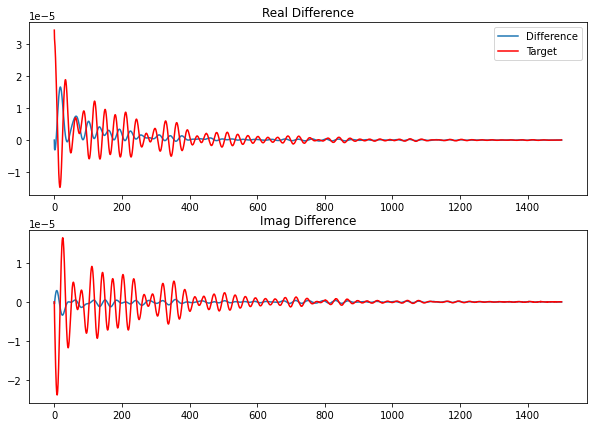

In [31]:
plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax1.set_title('Real Difference')
#ax1.set_xscale('log')
ax1.plot(learn_domain* au2fs, learn_s - plot_r.detach().numpy().flatten(),label ='Difference')
ax1.plot(learn_domain* au2fs, learn_s, 'r-',label ='Target')

ax1.legend()

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_title('Imag Difference')
#ax2.set_xscale('log')
ax2.plot(learn_domain* au2fs, learn_a - plot_i.detach().numpy().flatten(),label ='Difference')
ax2.plot(learn_domain* au2fs, learn_a , 'r-',label ='Target')
#ax2.plot(test_domain, test_a, 'y-',label ='learn')
plt.show()

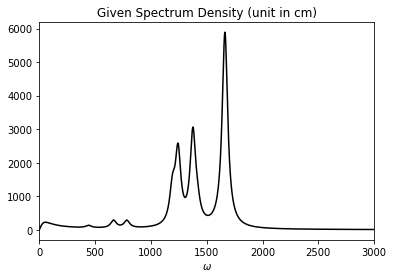

In [33]:
# reproduce new J_w
imag_part_bcf = plot_i.detach().numpy().flatten()
#file = open('SPD-TMP.txt','r')
file = open('sp_3_21.csv', 'r')# wider range spd
#sd = np.loadtxt(file, delimiter = "\t", dtype = float)
w, col_2 = np.loadtxt(file, delimiter = ",")
#learn_s,learn_a = np.loadtxt(file_learn ,delimiter = ",")
#w = sd[:, 0]
#col_2 = sd[:, 1]
#os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.plot(w, col_2, 'k-')
plt.xlim(0,3000)
plt.xlabel('$\omega$')
plt.title('Given Spectrum Density (unit in cm)')
plt.show()

def get_j(imag_part, t, beta, w):
    y = imag_part * np.sin(w * t)
    return -integrate.simpson(y, x=t)

beta = 1052.6
def Gaussian(x, x0, sigma):
    return np.exp(-(x - x0)**2/(2*sigma**2))/(2 * np.pi*sigma**2)

x = np.linspace(-100, 100, len(w))
#d = sd[:, 1] / au2cm#np.convolve(sd[1:, 1] / au2cm, Gaussian(x, 0, 5),'same')
#plt.plot(w, d)#sd[1:, 1]/ au2cm)
#plt.show()
_10000 = np.where(w<10000)
new_J = np.array([get_j(imag_part_bcf, learn_domain, 1052.6, w_i/au2cm) for w_i in w[_10000]])

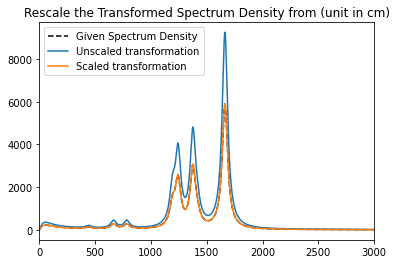

In [34]:
def FTo(odd, t, w):
    y = odd * np.sin(w * t)
    return -integrate.simpson(y, x=t)
_10000 = np.where(w<10000)
Odd_trans = np.array([FTo(col_2[_10000]/au2cm, w[_10000]/ au2cm, t_i) for t_i in learn_domain])
Odd_back = np.array([FTo(Odd_trans, learn_domain, w_i/au2cm) for w_i in w[_10000]])

ratio = max(Odd_back)/max(col_2/au2cm)
plt.plot(w[_10000], col_2[_10000],'k--', label = 'Given Spectrum Density')
plt.plot(w[_10000], Odd_back*au2cm, label = 'Unscaled transformation')
plt.plot(w[_10000], Odd_back*au2cm/ratio, label = 'Scaled transformation')
plt.title('Rescale the Transformed Spectrum Density from (unit in cm)')
plt.xlim(0,3000)
plt.legend()
plt.show()

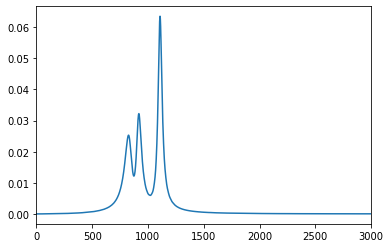

In [42]:
plt.plot(w[_10000],new_J)
plt.xlim(0,3000)
plt.show()

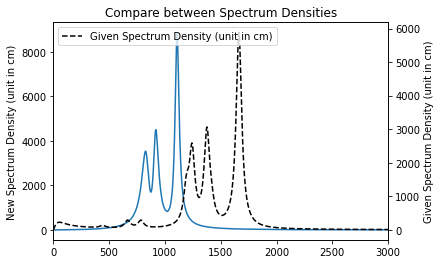

C:\Users\ALIENW~1\AppData\Local\Temp/ipykernel_16548/860474058.py:22: RuntimeWarning: overflow encountered in exp
  plt.plot(learn_domain*au2fs, np.exp(r_t)/2 ,label = "$\Gamma(t)$")


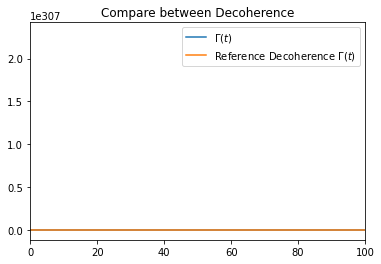

'r_t_ratio = max(np.abs(r_t_0))/max(np.abs(r_t))\nplt.plot(t*au2fs, np.exp(r_t* r_t_ratio)/2,label = "$\\Gamma(t)$")\nplt.plot(t*au2fs, np.exp(r_t_0)/2,label = "Reference Decoherence $\\Gamma(t)$")\nplt.title(\'Try to rescale\')\nplt.legend()\nplt.show()'

In [45]:
fig, ax = plt.subplots()
ax.plot(w[_10000], new_J*au2cm/ratio)
ax.set_ylabel('New Spectrum Density (unit in cm)')
ax_twinx = ax.twinx()
#ax_twinx.plot(w, sd[1:, 1],'k--',label = 'Given Spectrum Density (unit in cm)')
ax_twinx.plot(w[_10000], col_2[_10000],'k--',label = 'Given Spectrum Density (unit in cm)')
ax_twinx.set_ylabel('Given Spectrum Density (unit in cm)')
ax.set_title('Compare between Spectrum Densities')
ax.set_xlim(0, 3000)
plt.legend(loc = 'upper left')
#ax_twinx.legend(loc = 'lower left')
plt.show()

def Gamma(j, w, beta, t):
    y = j/w**2 * (1 - np.cos(w * t))/ np.tanh(beta * w / 2.0)
    return -integrate.simpson(y, x=w)

t_range = np.where(learn_domain*au2fs <= 100)
t = learn_domain[t_range]
r_t = np.array([Gamma(new_J/ratio, w[_10000]/ au2cm, 1052.6, t_i) for t_i in learn_domain])
r_t_0 = np.array([Gamma(col_2[_10000]/au2cm, w[_10000]/ au2cm, 1052.6, t_i) for t_i in learn_domain])
plt.plot(learn_domain*au2fs, np.exp(r_t)/2 ,label = "$\Gamma(t)$")
plt.plot(learn_domain*au2fs, np.exp(r_t_0)/2 ,label = "Reference Decoherence $\Gamma(t)$")
plt.title('Compare between Decoherence')
plt.legend()
plt.xlim(0,100)
plt.show()

"""r_t_ratio = max(np.abs(r_t_0))/max(np.abs(r_t))
plt.plot(t*au2fs, np.exp(r_t* r_t_ratio)/2,label = "$\Gamma(t)$")
plt.plot(t*au2fs, np.exp(r_t_0)/2,label = "Reference Decoherence $\Gamma(t)$")
plt.title('Try to rescale')
plt.legend()
plt.show()"""

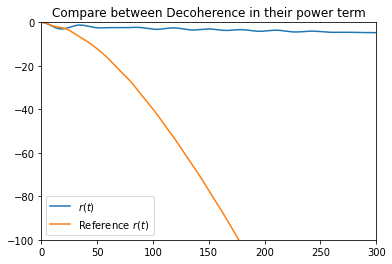

In [49]:
plt.plot(learn_domain*au2fs, r_t ,label = "$r(t)$")
plt.plot(learn_domain*au2fs, r_t_0 ,label = "Reference $r(t)$")
plt.title('Compare between Decoherence in their power term')
plt.legend()
plt.xlim(0,300)
plt.ylim(-100,0)
plt.show()

From that we can see that, there may still need to add an exponential $(c_r+c_ii)exp(-st)$
which means the c_r and c_i for the a=0 peak is not so correct,
problem might be:
1. s is incorrect
2. s is correct but c is incorrect

Let's generate standing wave and find out why it will have such difference!

In [43]:
def get_j_re(j, w, beta, t):
    y = j * np.cos(w * t)#/ np.tanh(beta * w / 2.0)
    return integrate.simpson(y, x=w)#*np.tanh(beta * w[_10000]/au2cm / 2.0)
new_J_re = np.array([get_j_re(plot_r.detach().numpy().flatten(), learn_domain, 1052.6, w_i/au2cm) for w_i in w[_10000]])

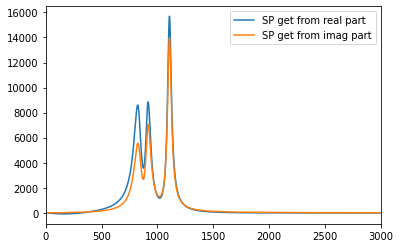

In [44]:
plt.plot(w[_10000],new_J_re*au2cm*np.tanh(beta * w[_10000]/au2cm / 2.0), label = 'SP get from real part')
plt.plot(w[_10000], (new_J)*au2cm, label = 'SP get from imag part')
plt.legend()
plt.xlim(0,3000)
plt.show()